In [ ]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import cf_xarray as cfxr

from sklearn.linear_model import LinearRegression
import scipy.signal as signal
from scipy import stats
from datetime import timedelta

import seaborn as sns
import matplotlib as mpl
import cmocean
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import string
alphabet = list(string.ascii_lowercase)       

In [ ]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

# Import data

## Green's Function

In [ ]:
G_ds = xr.open_dataset('Outputs/G_ds.nc4')['__xarray_dataarray_variable__']

G_CDR_ds = xr.open_dataset('Outputs/G_cdr_ds.nc4')['__xarray_dataarray_variable__']

#4th order polyfit
Gpoly = G_ds.polyfit('year', 4)
G_ds= xr.polyval(G_ds.year, Gpoly)['polyfit_coefficients']

Gpoly_cdr = G_CDR_ds.polyfit('year', 4)
G_CDR_ds= xr.polyval(G_CDR_ds.year, Gpoly_cdr)['polyfit_coefficients']

In [ ]:
G_ds = xr.concat([G_ds, -G_CDR_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))


In [ ]:
G_ds.name = 'G[tas]'
G_ds = G_ds.rename({'year':'s'})


## Convolution

In [6]:
conv_mean_ds = xr.open_dataset('Outputs/ssp245_conv_mean_ds.nc4')['__xarray_dataarray_variable__']

conv_ds = xr.open_dataset('Outputs/ssp245_conv_ds.nc4')['__xarray_dataarray_variable__']

## CMIP6 SSP245

In [7]:
ds_dif = xr.open_dataset('Outputs/ssp245_ds_dif.nc4')

In [8]:
ds_dif = ds_dif.where(ds_dif.s >= 165, drop = True)
ds_dif['s'] = np.arange(0, len(ds_dif['s']))

## CMIP6 SSP245 GHG

In [9]:
ds_dif_GHG = xr.open_dataset('Outputs/ssp245_GHG_ds_dif.nc4')

ds_dif_GHG = ds_dif_GHG.where(ds_dif_GHG.s >= 165, drop = True)
ds_dif_GHG['s'] = np.arange(0, len(ds_dif_GHG['s']))

## CMIP6 SSP245 Nat

In [10]:
ds_dif_nat = xr.open_dataset('Outputs/ssp245_nat_ds_dif.nc4')

ds_dif_nat = ds_dif_nat.where(ds_dif_nat.s >= 165, drop = True)
ds_dif_nat['s'] = np.arange(0, len(ds_dif_nat['s']))

## Emissions profile

In [11]:
emis_profile = xr.open_dataset('Outputs/ssp245_emis_profile.nc4')


## Pre-Industrial Control

In [12]:
ds_pictrl = xr.open_dataset('Outputs/ds_pictrl.nc4')

## Model Dicts

In [13]:
model_run_pulse_dict = utils.model_run_pulse_dict
model_run_cdr_pulse_dict = utils.model_run_cdr_pulse_dict

model_run_hist_dict = {'CANESM5_r1p1':'CanESM5-1_historical_r1i1p1f1*'}
model_run_control_dict = {'CANESM5_r1p1':'CanESM5-1_piControl_r1i1p1f1*'}
model_run_ssp245_dict = {'CANESM5_r1p1':'CanESM5-1_ssp245_r1i1p1f1*'}


# Settings and Define our Model Weights

In [14]:
#define our weights for models (grouping UKESM and CANESM realizations)
model_weights = utils.model_weights

onepct_model_weights = utils.onepct_model_weights

G_model_weights = utils.G_model_weights

pictrl_model_weights = utils.pictrl_model_weights

In [15]:
type_color = utils.type_color
model_color = utils.model_color

In [16]:
A = utils.A
ds_out = utils.ds_out

In [17]:
proper_names = utils.proper_names

# Plots

## Emissions profile

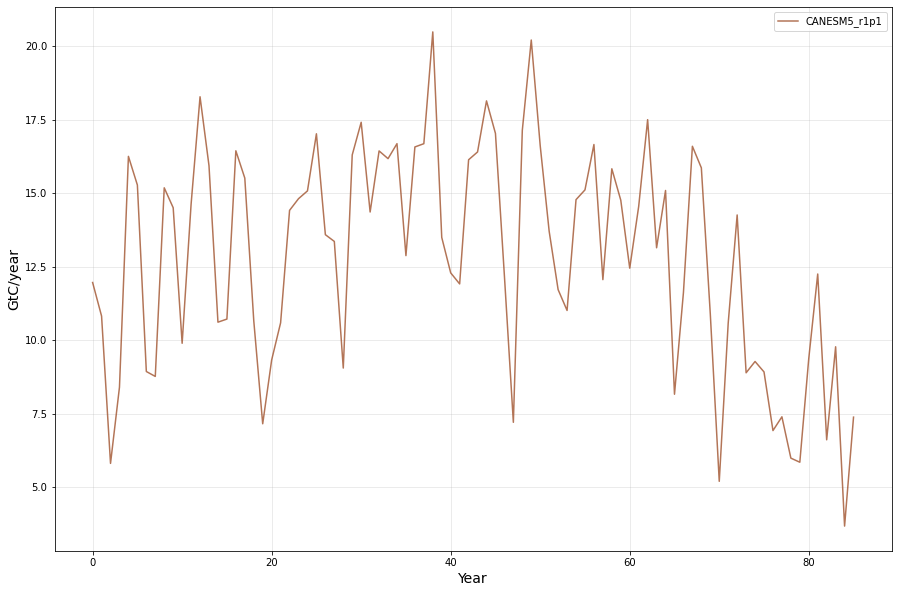

In [17]:
fig, ax = plt.subplots(figsize = [15,10])
for m in ['CANESM5_r1p1']:
    plt.plot(emis_profile.sel(model = m)['emis'], alpha = .8, label = f'{m}', color = model_color[m])
#plt.plot(emis_profile.mean(dim = 'model')['emis'], color = 'k', label = f'Model Mean')
plt.legend()
plt.xlabel('Year', fontsize = 14)
plt.ylabel('GtC/year', fontsize = 14)
plt.grid(alpha = .3)


## Warming without the CO2

In [18]:
m = 'CANESM5_r1p1'

In [19]:
no_co2 = ds_dif['tas']-conv_ds.mean(dim = 'pulse_type') #all historical forcing + forcing from everything but future (SSP) CO2
other_GHG = ds_dif_GHG['tas']-conv_ds.mean(dim = 'pulse_type') #all historical forcing + forcing from just other GHG (future)

(0.0, 85.0)

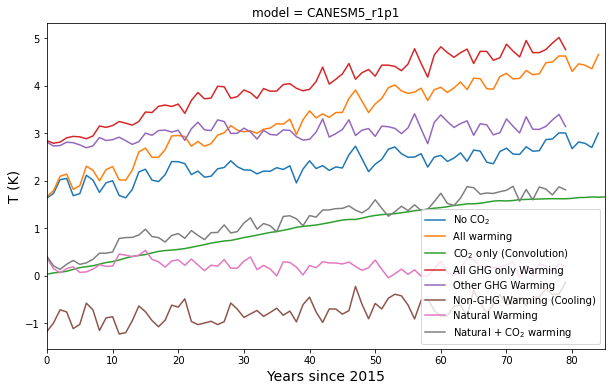

In [27]:
fig, ax = plt.subplots(figsize = (10,6))
no_co2.weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(label = 'No CO$_2$')
ds_dif['tas'].weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(label = 'All warming')
conv_ds.mean(dim = 'pulse_type').weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(label = 'CO$_2$ only (Convolution)')
ds_dif_GHG['tas'].weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(label = 'All GHG only Warming')
other_GHG.weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(label = 'Other GHG Warming')
(ds_dif - ds_dif_GHG)['tas'].weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(label = 'Non-GHG Warming (Cooling)')
ds_dif_nat['tas'].weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(label = 'Natural Warming')
(ds_dif_nat['tas'] + conv_ds.mean(dim = 'pulse_type')).weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(label = 'Natural + CO$_2$ warming')



plt.ylabel('T (K)', fontsize = 14)
plt.xlabel('Years since 2015', fontsize = 14)
plt.legend()
plt.xlim(0,85)

(0.0, 85.0)

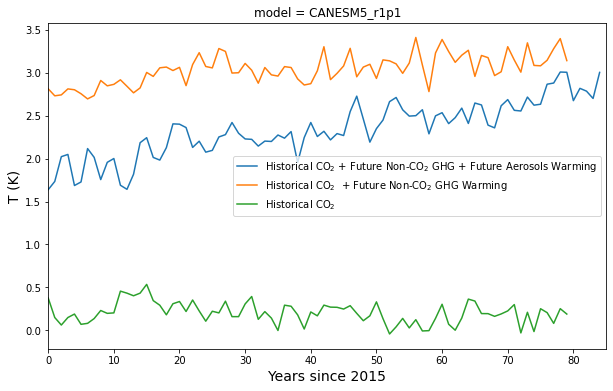

In [22]:
fig, ax = plt.subplots(figsize = (10,6))
no_co2.weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(label = 'Historical CO$_2$ + Future Non-CO$_2$ GHG + Future Aerosols Warming')
other_GHG.weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(label = 'Historical CO$_2$  + Future Non-CO$_2$ GHG Warming')
ds_dif_nat['tas'].weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(label = 'Historical CO$_2$')



plt.ylabel('T (K)', fontsize = 14)
plt.xlabel('Years since 2015', fontsize = 14)
plt.legend()
plt.xlim(0,85)

# Map of what the underlying data for EnROADS Looks like

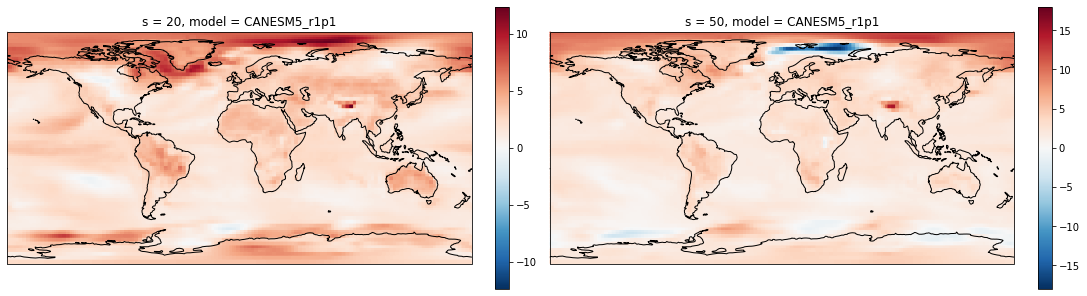

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [15,4], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)
t1 = 20
no_co2.sel(model = m, s = t1).plot(ax = ax1, transform = ccrs.PlateCarree())
t2 = 50
no_co2.sel(model = m, s = t2).plot(ax = ax2, transform = ccrs.PlateCarree())

ax1.coastlines()
ax2.coastlines()

# Save out the Historical Forcing (all) + Future forcing (minus CO2)

This is the estimated T change we will use for underlying EnROADS

In [ ]:
no_co2.to_netcdf('Outputs/EnROADS_baseline.nc')